# **Convolutional Neural Network Filter Bank for Musical Instruments Classification**

# Professor Supervisor: Prof. Gerald Schuller
# Research Assistant Supervisor: Renato de C. R. Profeta
# Author: Param Tushar Gadam
# Date: 1st June, 2020
# Master of Science in Communications and Signal Processing, Ilmenau University of Technology, Germany

# **Colab Runtime Configurations**

In [1]:
# Install torchaudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1.9MB 25.5MB/s 


# **Imports and Configuration**

In [2]:
# Imports

## Numerical Computing
import numpy as np
import itertools

## File System and Files Handling
import os
from zipfile import ZipFile

## Python Serialization
import pickle

## Audio Processing
import librosa.display, librosa
import torchaudio

## Plotting and Visualization
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.core.display import HTML, display, Image

## Machine Learning ´
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import mean_squared_error

## Deep Learning
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import math

In [3]:
# Seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [5]:
## Check CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#map_location=torch.device('cpu')
#please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.
#torch.load(map_location)

cuda


In [6]:
# Configure Tensorboard
%load_ext tensorboard

In [7]:
#logs_base_dir = "runs"
#os.makedirs(logs_base_dir, exist_ok=True)

# **Download the dataset from Dropbox**

In [8]:
# Download the dataset from Dropbox
!wget -O dataset.zip https://www.dropbox.com/s/su4rvaipccm1lit/all-samples_npy_pkl.zip?dl=0

--2021-06-01 20:16:13--  https://www.dropbox.com/s/su4rvaipccm1lit/all-samples_npy_pkl.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/su4rvaipccm1lit/all-samples_npy_pkl.zip [following]
--2021-06-01 20:16:13--  https://www.dropbox.com/s/raw/su4rvaipccm1lit/all-samples_npy_pkl.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce000f85ca818e0785fe4ca86ce.dl.dropboxusercontent.com/cd/0/inline/BPkzlImsSpT6yI33FcQDHV0LAmyrg_e1WW32EtFOUfDbJh6gsfFKqeCpnDuy0jPsUedPKgD5v7YLNsi5i0ZFbiFSAtueLdEHzItMnWEA2UfENgvYththXX_5m6Y8AcE-2pX990mm2AnuclSFzgZB_3CG/file# [following]
--2021-06-01 20:16:14--  https://uce000f85ca818e0785fe4ca86ce.dl.dropboxusercontent.com/cd/0/inline/BPkzlImsSpT6yI33FcQDHV0LAmyrg_e1WW32EtFOUfDbJh6gsfFK

# **Extract .zip**

In [9]:
with ZipFile('dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

# **Get Dataset Metadata from GitHub**

In [10]:
# Clone github in Google Colab
!git clone https://github.com/param1707/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-.git

Cloning into '-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-'...
remote: Enumerating objects: 2521, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 2521 (delta 17), reused 24 (delta 9), pack-reused 2483
Receiving objects: 100% (2521/2521), 2.07 GiB | 46.69 MiB/s, done.
Resolving deltas: 100% (1483/1483), done.
Checking out files: 100% (412/412), done.


In [11]:
# Load Train Set
with open('./-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/datasetMetadata/train_set_dataframe.pkl', 'rb') as f:
  train_set = pickle.load(f)
#Load Test Set
with open('./-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/datasetMetadata/test_set_dataframe.pkl', 'rb') as f:
  test_set = pickle.load(f)

# **Encode Labels**

In [12]:
# Encode Labels Test Set
labelencoder = LabelEncoder()
labelencoder.fit(test_set['class'].values.tolist())
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_int_test = labelencoder.transform(test_set['class'].values.tolist())

#OneHotEncoding
encoder=OneHotEncoder(sparse=False, categories="auto")
onehot_labels_test=encoder.fit_transform(classes_int_test.reshape(len(classes_int_test),1))

20 classes: banjo, bass-clarinet, bassoon, cello, clarinet, contrabassoon, double-bass, english-horn, flute, french-horn, guitar, mandolin, oboe, percussion, saxophone, trombone, trumpet, tuba, viola, violin


# **Create PyTorch Datasets for Training and Testing**

In [13]:
# Dataset Class
class dataset(Dataset):
    """An abstract class representing a Dataset.

    Author: Renato de Castro Rabelo Profeta, October 2020, TU Ilmenau Germany
    """
    def __init__(self, files, labels):
        self.labels = labels
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
      x_numpy = np.load(self.files[index])
      X = torch.from_numpy(x_numpy)
      X /= torch.abs(X).max()  # Normalize
      X = torch.reshape(X,(1,-1)) # Reshape for Model
      y_labels = torch.tensor(self.labels[index]) #Labels Out
      return X,y_labels

In [16]:
# Create Sets
#train_set_torch = dataset(train_set['filename'].values.tolist(), onehot_labels_train)
test_set_torch = dataset(test_set['filename'].values.tolist(), onehot_labels_test)

In [17]:
# Data Loader.
#training_generator = DataLoader(train_set_torch, batch_size=1, shuffle=False, num_workers=0)
validation_generator = DataLoader(test_set_torch, batch_size=1, shuffle=False, num_workers=0)

# **Testing Dataset and Dataloader**

In [18]:
# Get a random audio file and label from dataset
dataiter = iter(DataLoader(test_set_torch, batch_size=1, shuffle=True, num_workers=0))
audio_to_test, label_to_test = dataiter.next()

In [19]:
# Calculate Spectrogram of the audio file to test
specgram = torchaudio.transforms.Spectrogram(n_fft=2048)(audio_to_test[0,0,:])

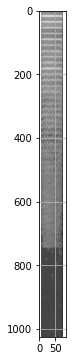

In [20]:
# Plot Spectrogram of audio to test
plt.figure(figsize=(10,6))
plt.imshow(20*specgram.log10().numpy(), cmap='gray')
plt.grid()

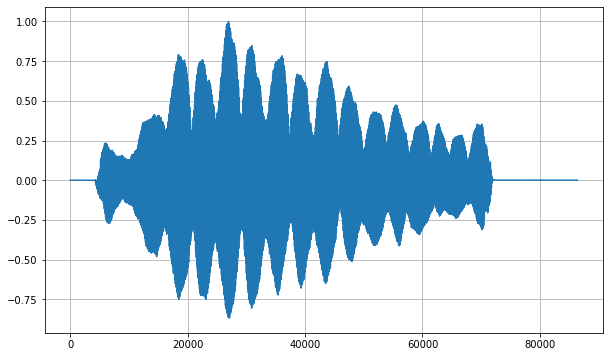

In [21]:
# Plot Waveform of audio to test
plt.figure(figsize=(10,6))
plt.plot(audio_to_test[0,0,:])
plt.grid()

In [22]:
# Listen to audio
ipd.Audio(audio_to_test[0,0,:], rate=44100) # load a local WAV file

# **Experiment Results for experiment 2**

#  load pickle file needed for plotting results for experiment 2

In [23]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/histexp2.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
print(hist)

In [26]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 755 (out of 3421)
Validation correct 2666 (out of 3421)


In [27]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])

for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

print(type(rmse_all_pred))
print(rmse_all_pred[0])


#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

(array([   0,    2,    5, ..., 3417, 3419, 3420]),)
<class 'list'>
[array(0.00077329, dtype=float32)]


In [28]:
test_list = test_set['duration'].values.tolist()
print((test_list))
print(wrong_pred [0][754])
print(test_list[wrong_pred [0][754]])

[1.123265306122449, 0.6008163265306122, 2.1681632653061222, 1.123265306122449, 1.0971428571428572, 1.2277551020408164, 0.5485714285714286, 0.9926530612244898, 0.39183673469387753, 1.0710204081632653, 0.5224489795918368, 0.3395918367346939, 0.9404081632653061, 0.6791836734693878, 1.9591836734693877, 1.0971428571428572, 1.3061224489795917, 1.2016326530612245, 3.5787755102040815, 1.8808163265306121, 0.6008163265306122, 0.5485714285714286, 3.082448979591837, 0.4179591836734694, 0.47020408163265304, 1.8808163265306121, 1.0710204081632653, 1.8808163265306121, 1.8024489795918368, 1.28, 1.8808163265306121, 1.3322448979591837, 1.28, 0.4440816326530612, 0.5224489795918368, 0.809795918367347, 0.2873469387755102, 0.6008163265306122, 1.3061224489795917, 1.3061224489795917, 1.123265306122449, 1.5151020408163265, 1.8285714285714285, 1.5412244897959184, 0.7053061224489796, 5.877551020408164, 0.9926530612244898, 0.9404081632653061, 0.9926530612244898, 0.6530612244897959, 0.7575510204081632, 1.149387755

In [29]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [30]:
print(len(correct_pred_value))

2666


In [31]:
ranges_dur = np.linspace(0,25, num=100)
print(ranges_dur)
print(np.round(ranges_dur,2))


[ 0.          0.25252525  0.50505051  0.75757576  1.01010101  1.26262626
  1.51515152  1.76767677  2.02020202  2.27272727  2.52525253  2.77777778
  3.03030303  3.28282828  3.53535354  3.78787879  4.04040404  4.29292929
  4.54545455  4.7979798   5.05050505  5.3030303   5.55555556  5.80808081
  6.06060606  6.31313131  6.56565657  6.81818182  7.07070707  7.32323232
  7.57575758  7.82828283  8.08080808  8.33333333  8.58585859  8.83838384
  9.09090909  9.34343434  9.5959596   9.84848485 10.1010101  10.35353535
 10.60606061 10.85858586 11.11111111 11.36363636 11.61616162 11.86868687
 12.12121212 12.37373737 12.62626263 12.87878788 13.13131313 13.38383838
 13.63636364 13.88888889 14.14141414 14.39393939 14.64646465 14.8989899
 15.15151515 15.4040404  15.65656566 15.90909091 16.16161616 16.41414141
 16.66666667 16.91919192 17.17171717 17.42424242 17.67676768 17.92929293
 18.18181818 18.43434343 18.68686869 18.93939394 19.19191919 19.44444444
 19.6969697  19.94949495 20.2020202  20.45454545 20.

Duration histograms for wrong and correct predictions for experiment2

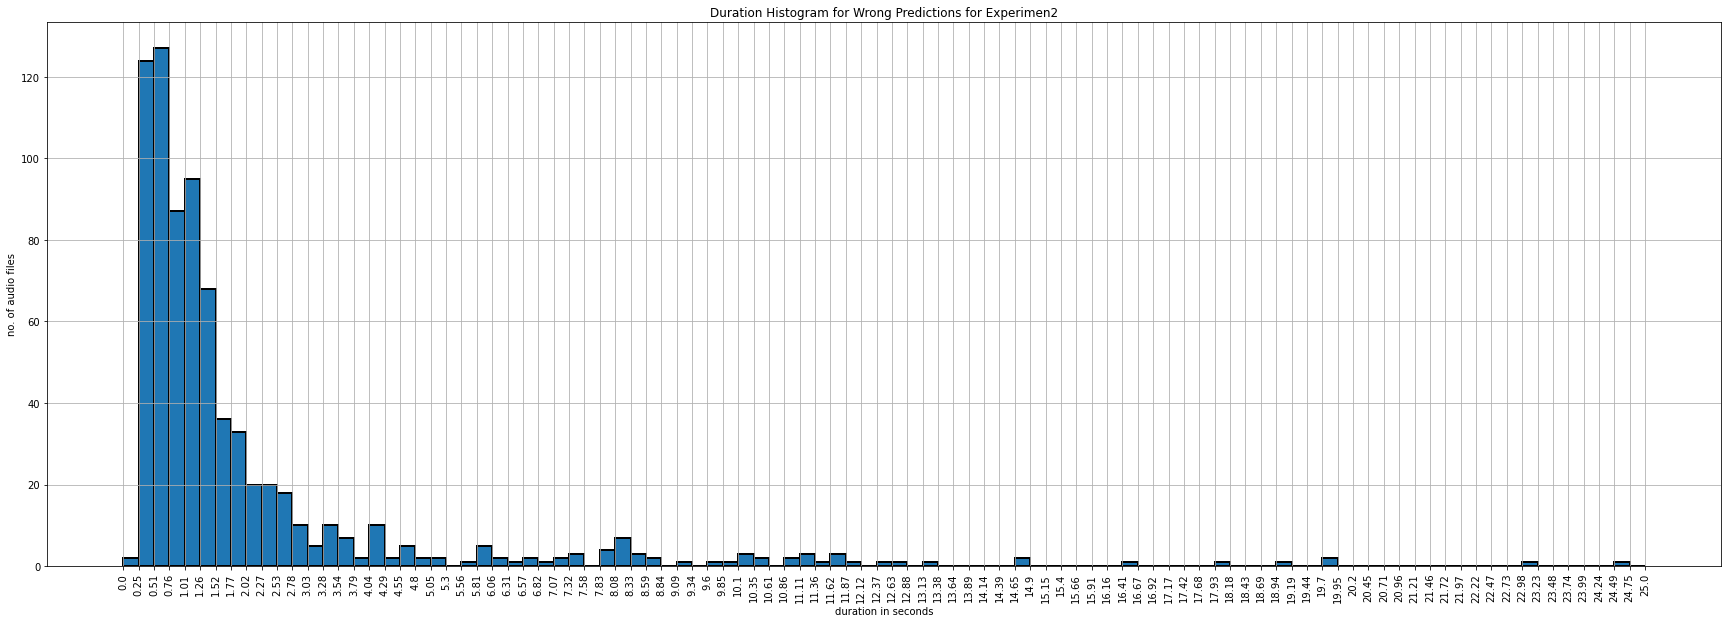

In [32]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Experimen2")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

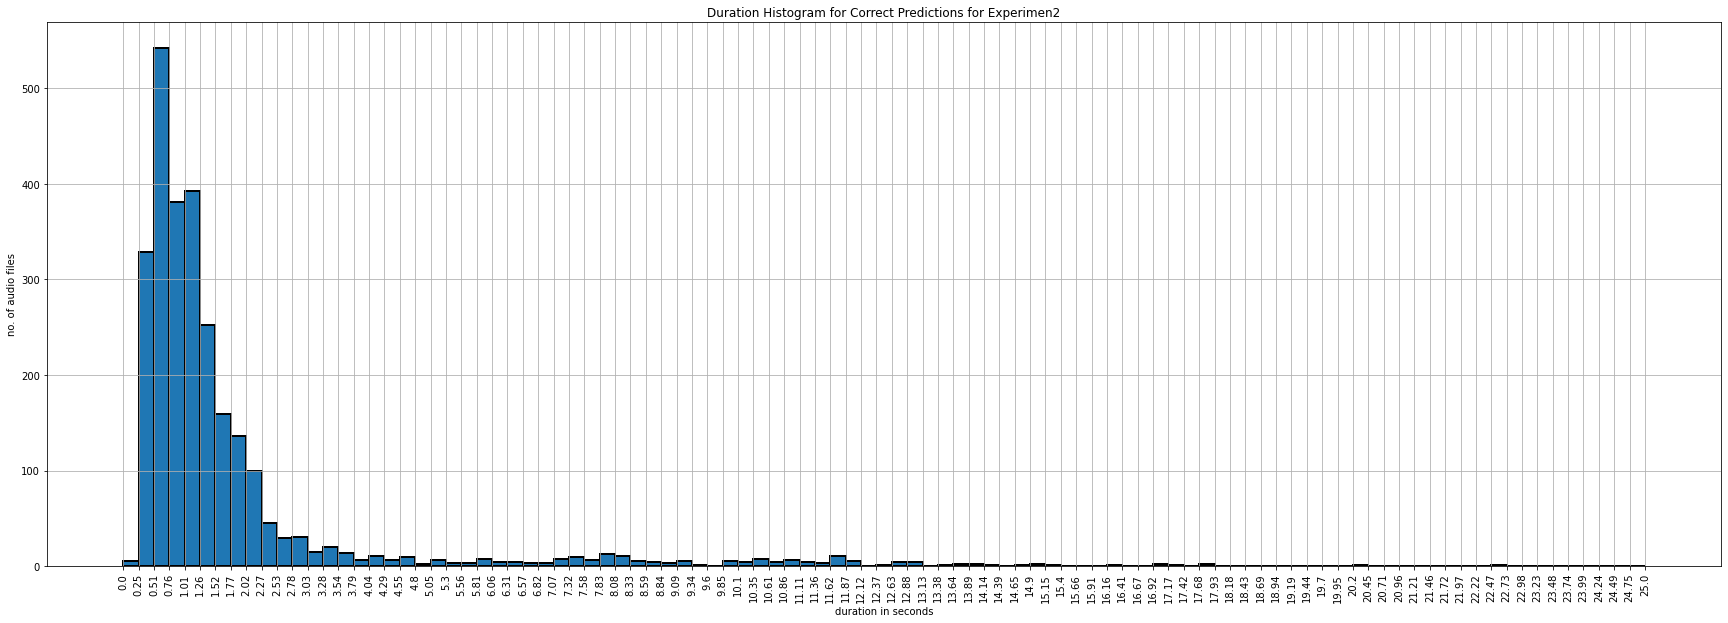

In [33]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Experimen2")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for experiment2

In [34]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

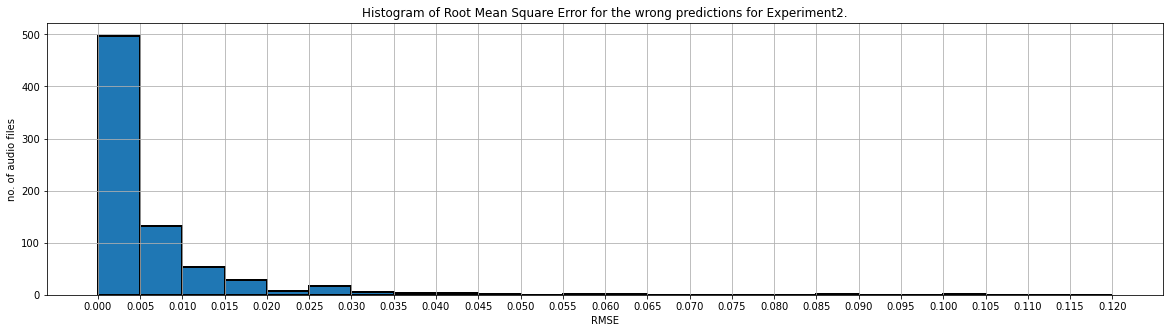

In [35]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Experiment2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

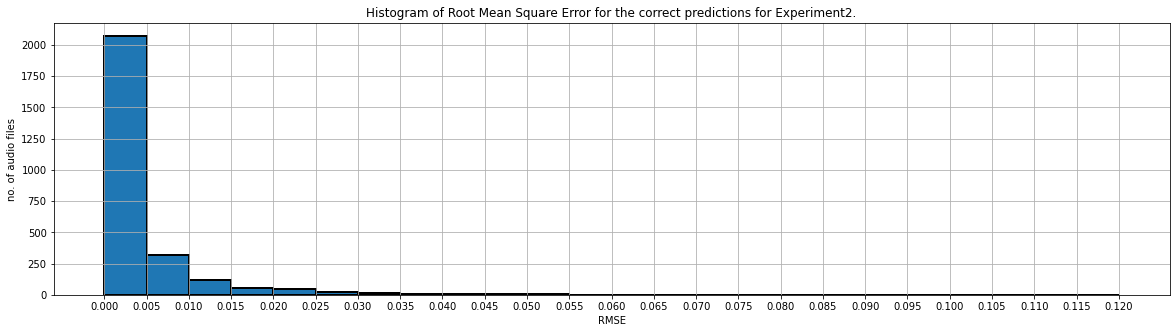

In [36]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Experiment2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

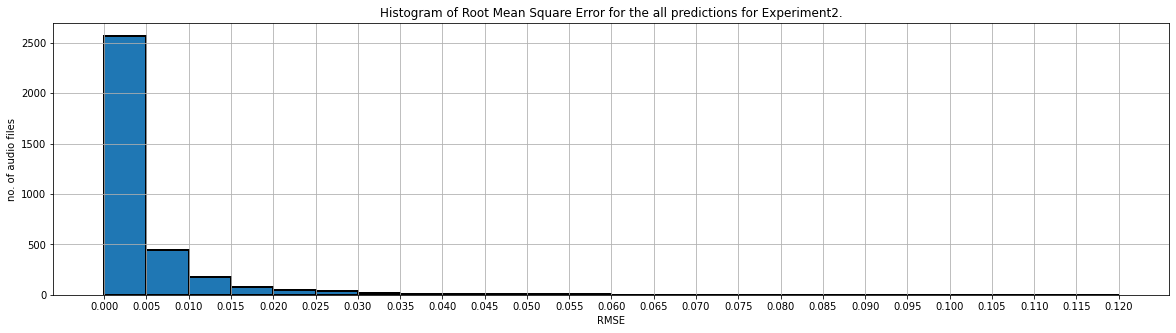

In [37]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Experiment2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [38]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Experiment2

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.83333333 0.91101695 0.78333333 0.58558559 0.78773585 0.87640449
 0.79812207 0.92485549 0.71818182 0.71779141 0.73076923 0.65
 0.73825503 0.51351351 0.76502732 0.875      0.65289256 0.85596708
 0.77366255 0.74202128]
Precision:  [0.88235294 0.84313725 0.72307692 0.70652174 0.78037383 0.87150838
 0.85       0.84210526 0.60076046 0.80689655 0.82608696 0.72222222
 0.77464789 0.55882353 0.8974359  0.84651163 0.58955224 0.82213439
 0.7611336  0.78151261]
F1-Score:  [0.85714286 0.87576375 0.752      0.64039409 0.78403756 0.87394958
 0.82324455 0.8815427  0.65424431 0.75974026 0.7755102  0.68421053
 0.75601375 0.53521127 0.8259587  0.86052009 0.61960784 0.83870968
 0.76734694 0.76125512]
Accuracy: 0.78  , 2666
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        18
           1       0.84      0.91      0.88       236
           2       0.72      0.78      0.75       180
           3       0.71      0.59  

In [39]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [40]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

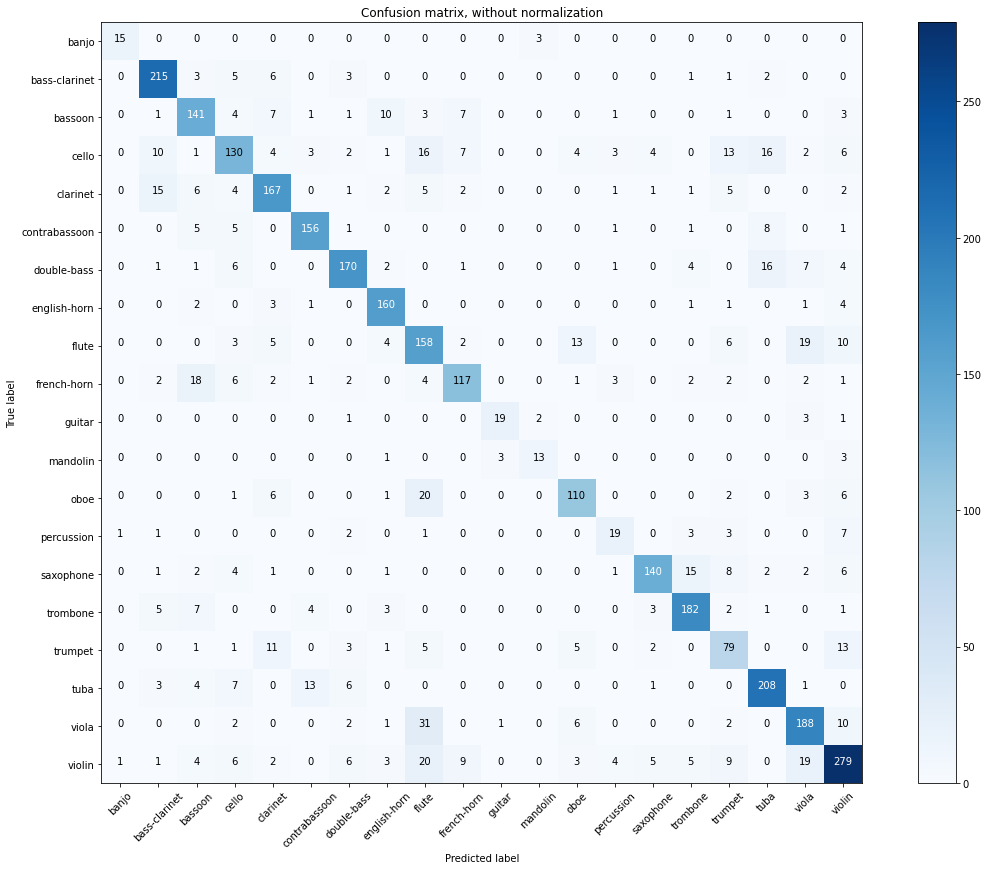

In [41]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

#  load pickle file needed for plotting results for experiment 2

In [ ]:
with open('/content/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/Experiment2/histexp2.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [ ]:
hist = hist1['hist']
print(hist)

In [ ]:
# Number of Validation Classification Errors
num_errors = torch.sum((torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation errors {} (out of {})'.format(int(num_errors), len(test_set)))
num_correct = torch.sum((torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))).float())
print('Validation correct {} (out of {})'.format(int(num_correct), len(test_set)))

Validation errors 755 (out of 3421)
Validation correct 2666 (out of 3421)


In [ ]:
# Validation Classification Mistakes
error_indicator = torch.tensor(hist["valid_predictions"]) != torch.tensor(np.argmax(onehot_labels_test,axis=1))
correct_indicator = torch.tensor(hist["valid_predictions"]) == torch.tensor(np.argmax(onehot_labels_test,axis=1))

#print(np.where(error_indicator[0,:]))
print(np.where(correct_indicator[0,:]))
wrong_pred = np.where(error_indicator[0,:])
#print(wrong_pred)
correct_pred =  np.where(correct_indicator[0,:])
nos_err = int(num_errors)
nos_corr = int(num_correct)
nos_all = len(test_set)

#print((int(num_errors)))
#print((int(num_correct)))
#print(wrong_pred[0][nos_err - 1])
#print(correct_pred[0][nos_corr - 1])
#print(nos_all)

rmse_wrong_pred = []
rmse_correct_pred = []
rmse_all_pred = []

for x in range(nos_err):
  rmse_wrong_pred.append(hist['valid_rmse'][0][(wrong_pred[0][x])])

for y in range(nos_corr):
  rmse_correct_pred.append(hist['valid_rmse'][0][(correct_pred[0][y])])

for z in range(nos_all):
  rmse_all_pred.append(hist['valid_rmse'][0][z])

print(type(rmse_all_pred))
print(rmse_all_pred[0])


#print(test_set['filename'].values[0])
#print(test_set['filename'].values[1])
#print(type(np.where(error_indicator[0,:])))

#print("Wrongly predicted Audio Files", test_set['filename'].values[np.where(error_indicator[0,:])])

#print("rmse of wrongly predicted audio files" , hist["valid_rmse"].values[np.where(error_indicator[0,:])])

#print("Correct Classes:", test_set['class'].values[np.where(error_indicator[0,:])])
#print("Predicted as:",labelencoder.inverse_transform(np.ravel(np.array(hist["valid_predictions"])[np.where(error_indicator)])))

(array([   0,    2,    5, ..., 3417, 3419, 3420]),)
<class 'list'>
[array(0.00077329, dtype=float32)]


In [ ]:
test_list = test_set['duration'].values.tolist()
print((test_list))
print(wrong_pred [0][754])
print(test_list[wrong_pred [0][754]])

[1.123265306122449, 0.6008163265306122, 2.1681632653061222, 1.123265306122449, 1.0971428571428572, 1.2277551020408164, 0.5485714285714286, 0.9926530612244898, 0.39183673469387753, 1.0710204081632653, 0.5224489795918368, 0.3395918367346939, 0.9404081632653061, 0.6791836734693878, 1.9591836734693877, 1.0971428571428572, 1.3061224489795917, 1.2016326530612245, 3.5787755102040815, 1.8808163265306121, 0.6008163265306122, 0.5485714285714286, 3.082448979591837, 0.4179591836734694, 0.47020408163265304, 1.8808163265306121, 1.0710204081632653, 1.8808163265306121, 1.8024489795918368, 1.28, 1.8808163265306121, 1.3322448979591837, 1.28, 0.4440816326530612, 0.5224489795918368, 0.809795918367347, 0.2873469387755102, 0.6008163265306122, 1.3061224489795917, 1.3061224489795917, 1.123265306122449, 1.5151020408163265, 1.8285714285714285, 1.5412244897959184, 0.7053061224489796, 5.877551020408164, 0.9926530612244898, 0.9404081632653061, 0.9926530612244898, 0.6530612244897959, 0.7575510204081632, 1.149387755

In [ ]:
wrong_pred_value = []
correct_pred_value = []
for a in range(nos_err):
  wrong_pred_value.append(test_list[wrong_pred [0][a]])

for b in range(nos_corr):
  correct_pred_value.append(test_list[correct_pred [0][b]])

In [ ]:
print(len(correct_pred_value))

2666


In [ ]:
ranges_dur = np.linspace(0,25, num=100)
print(ranges_dur)
print(np.round(ranges_dur,2))


[ 0.          0.25252525  0.50505051  0.75757576  1.01010101  1.26262626
  1.51515152  1.76767677  2.02020202  2.27272727  2.52525253  2.77777778
  3.03030303  3.28282828  3.53535354  3.78787879  4.04040404  4.29292929
  4.54545455  4.7979798   5.05050505  5.3030303   5.55555556  5.80808081
  6.06060606  6.31313131  6.56565657  6.81818182  7.07070707  7.32323232
  7.57575758  7.82828283  8.08080808  8.33333333  8.58585859  8.83838384
  9.09090909  9.34343434  9.5959596   9.84848485 10.1010101  10.35353535
 10.60606061 10.85858586 11.11111111 11.36363636 11.61616162 11.86868687
 12.12121212 12.37373737 12.62626263 12.87878788 13.13131313 13.38383838
 13.63636364 13.88888889 14.14141414 14.39393939 14.64646465 14.8989899
 15.15151515 15.4040404  15.65656566 15.90909091 16.16161616 16.41414141
 16.66666667 16.91919192 17.17171717 17.42424242 17.67676768 17.92929293
 18.18181818 18.43434343 18.68686869 18.93939394 19.19191919 19.44444444
 19.6969697  19.94949495 20.2020202  20.45454545 20.

Duration histograms for wrong and correct predictions for experiment2

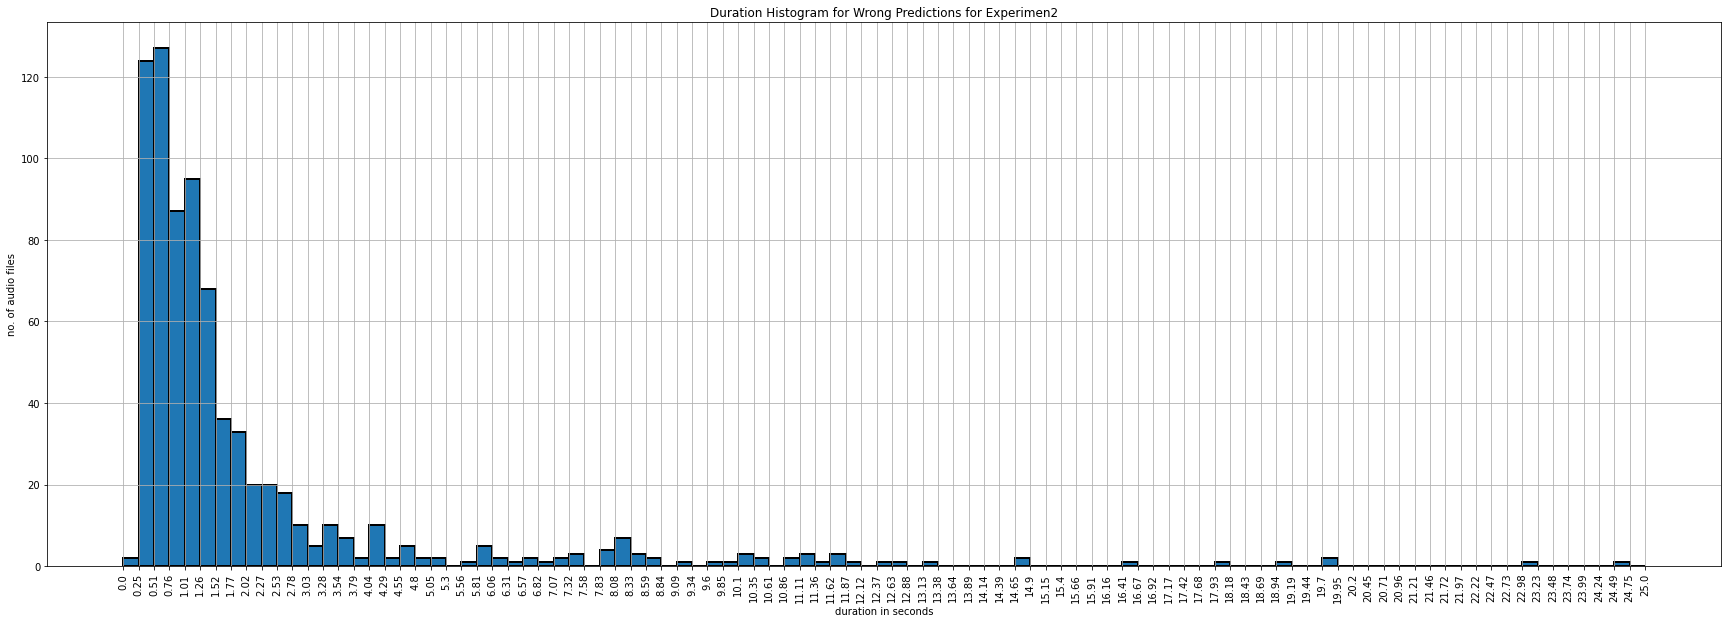

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(wrong_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Wrong Predictions for Experimen2")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

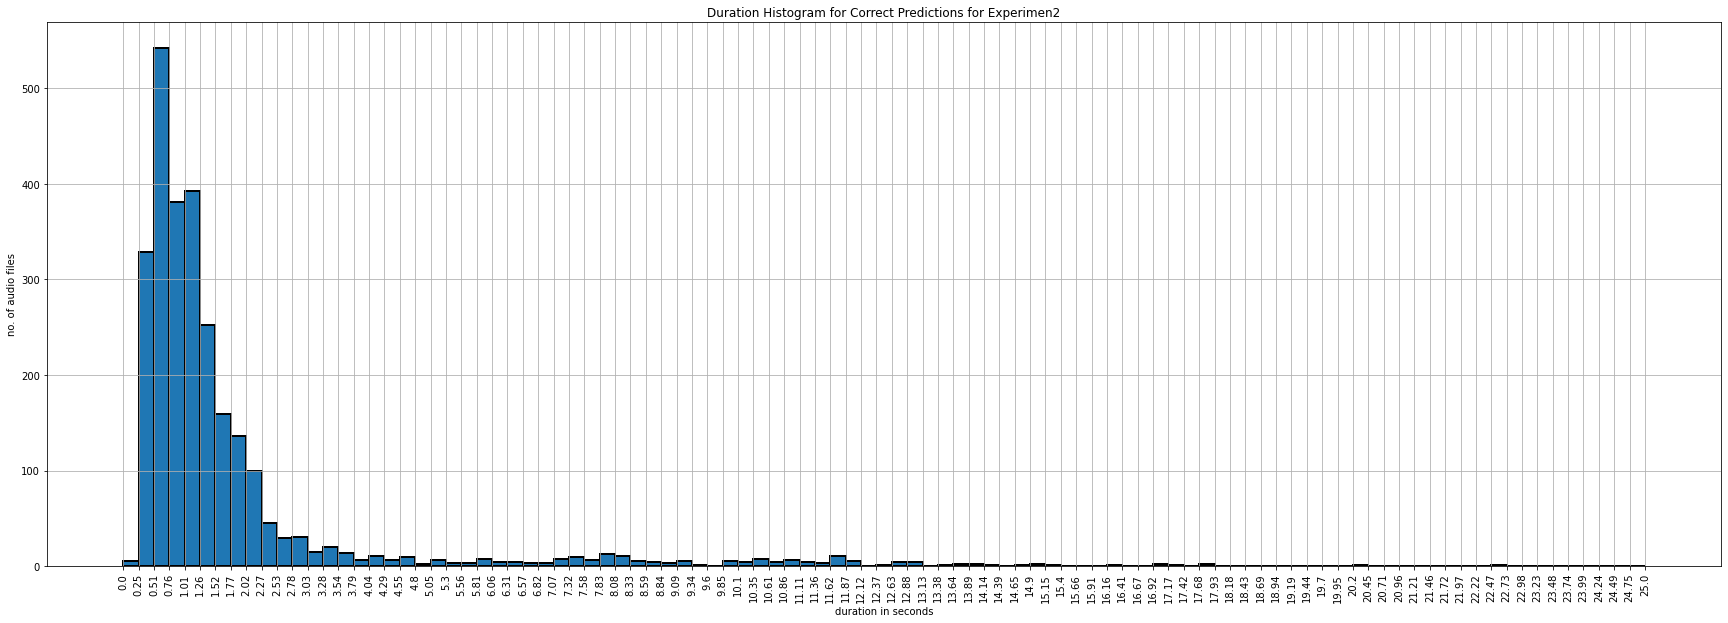

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
a = np.array(correct_pred_value)
ax.hist(a, bins = ranges_dur,edgecolor="black",linewidth=2)
#ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Duration Histogram for Correct Predictions for Experimen2")
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xticks(ranges_dur)
ax.set_xticklabels(np.round(ranges_dur,2), rotation=90)
ax.set_xlabel('duration in seconds')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

RMSE histograms for wrong , correct and all predictions for experiment2

In [ ]:
ranges_rmse = np.linspace(0.0000, 0.1200, num=25)

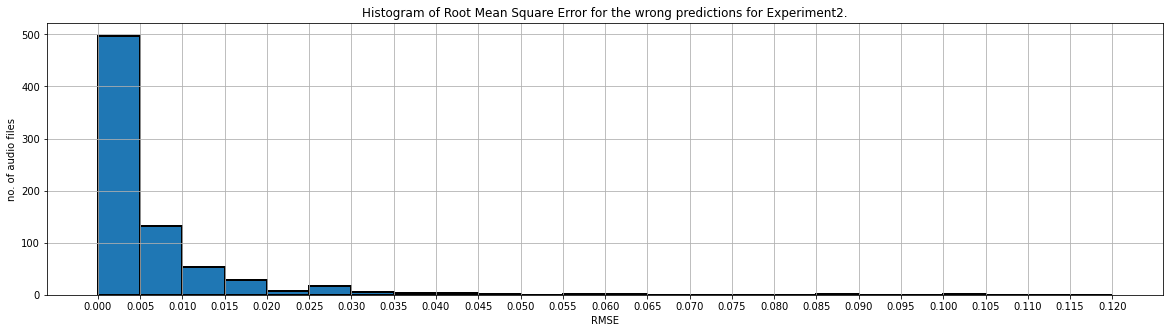

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_wrong_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the wrong predictions for Experiment2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

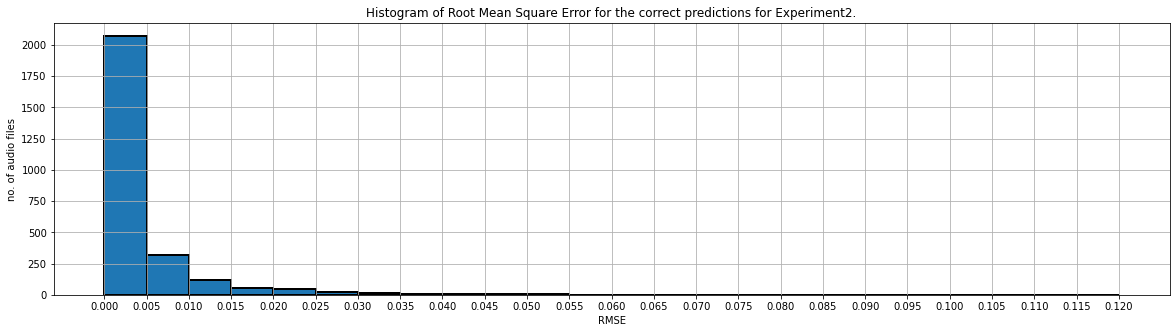

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_correct_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the correct predictions for Experiment2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

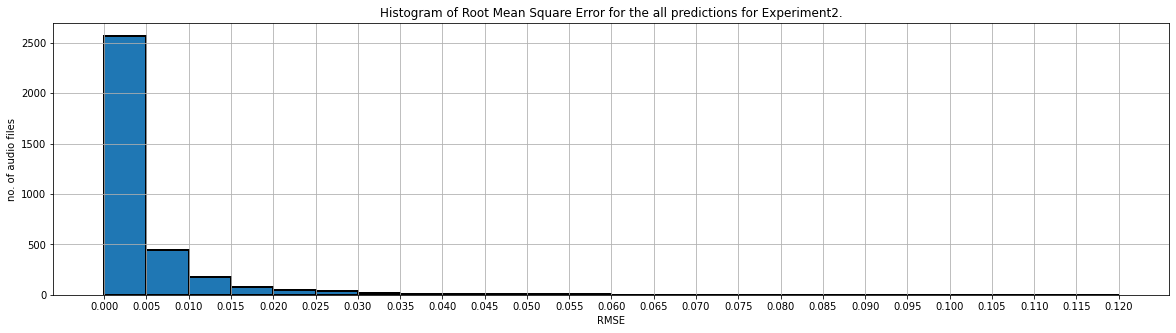

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

a = np.array(rmse_all_pred)
l1 = ax.hist(a, bins = ranges_rmse,edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300],edgecolor="black",linewidth=2)
#l1 = ax.hist(a, bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],edgecolor="black",linewidth=2)
ax.set_title("Histogram of Root Mean Square Error for the all predictions for Experiment2.")
ax.set_xticks(ranges_rmse)
#ax.set_xticks([0,0.0050,0.0100,0.0150,0.0200,0.0250,0.0300,0.0350,0.0400,0.0450,0.0500,0.0550,0.0600,0.0650,0.0700,0.0750,0.0800,0.0850,0.0900,0.0950,0.1000,0.1050,0.1100,0.1150,0.1200,0.1250,0.1300])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
ax.set_xlabel('RMSE')
ax.set_ylabel('no. of audio files')
ax.grid()
plt.show()

In [ ]:
# Back to Labels
predictions_labels=labelencoder.inverse_transform(np.ravel(hist["valid_predictions"]));

Score metrics for Experiment2

In [ ]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],average=None, zero_division=0))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_int_test, np.array(hist["valid_predictions"])[0,:], average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:] ,normalize=True), accuracy_score(classes_int_test, np.array(hist["valid_predictions"])[0,:],normalize=False) )
print("Number of samples:",classes_int_test.shape[0])

print(classification_report(classes_int_test, np.array(hist["valid_predictions"])[0,:], zero_division=0))

Recall:  [0.83333333 0.91101695 0.78333333 0.58558559 0.78773585 0.87640449
 0.79812207 0.92485549 0.71818182 0.71779141 0.73076923 0.65
 0.73825503 0.51351351 0.76502732 0.875      0.65289256 0.85596708
 0.77366255 0.74202128]
Precision:  [0.88235294 0.84313725 0.72307692 0.70652174 0.78037383 0.87150838
 0.85       0.84210526 0.60076046 0.80689655 0.82608696 0.72222222
 0.77464789 0.55882353 0.8974359  0.84651163 0.58955224 0.82213439
 0.7611336  0.78151261]
F1-Score:  [0.85714286 0.87576375 0.752      0.64039409 0.78403756 0.87394958
 0.82324455 0.8815427  0.65424431 0.75974026 0.7755102  0.68421053
 0.75601375 0.53521127 0.8259587  0.86052009 0.61960784 0.83870968
 0.76734694 0.76125512]
Accuracy: 0.78  , 2666
Number of samples: 3421
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        18
           1       0.84      0.91      0.88       236
           2       0.72      0.78      0.75       180
           3       0.71      0.59  

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_int_test, np.array(hist["valid_predictions"])[0,:])
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

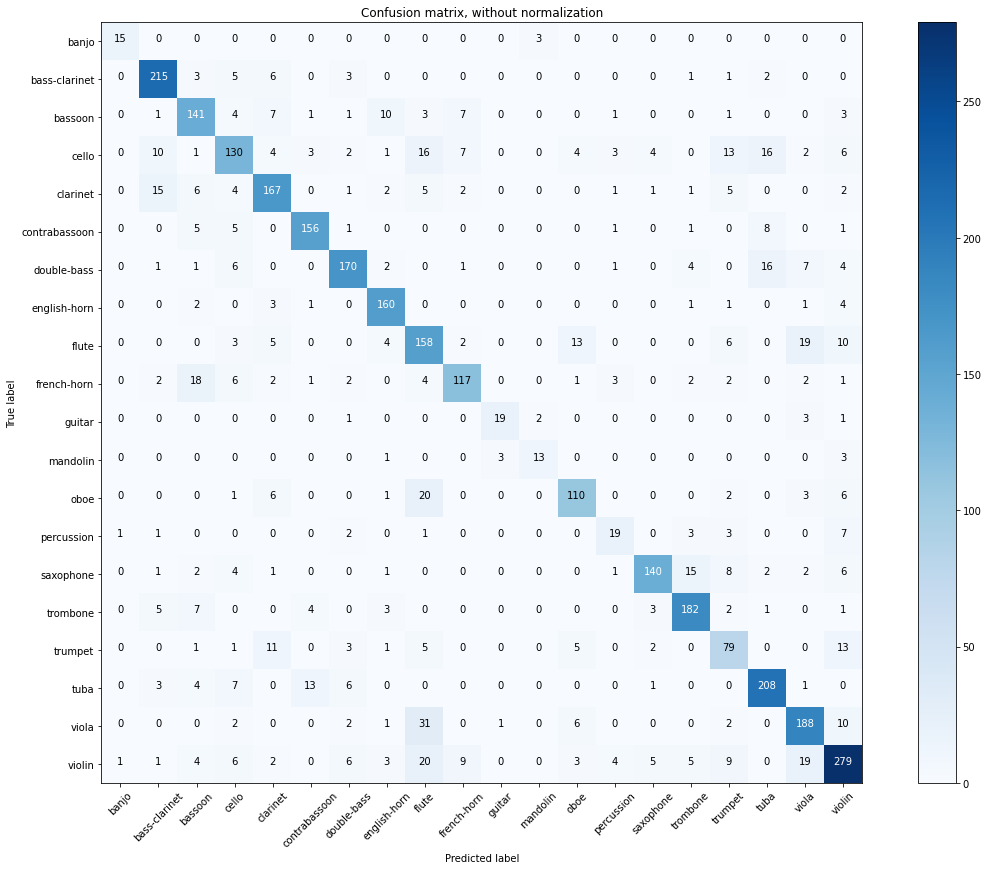

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')